In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
import numpy as np
import os
import librosa
import torch
from tqdm import tqdm
import pickle
from IPython.display import FileLink
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import torch.utils.data as data_utils
import torch.optim as optim
import random

In [53]:
from IPython.display import Audio
import matplotlib.pyplot as plt


# Filter

In [89]:
def get_energy(signal, sr, window_size=1024, hop_size=512, freq_range=(300, 3000)):
    frames = sg.windows.hann(window_size) * np.array(
        [signal[i : i + window_size] for i in range(0, len(signal) - window_size, hop_size)]
    )

    # Преобразование Фурье
    fft_frames = np.fft.rfft(frames, axis=1)
    freqs = np.fft.rfftfreq(window_size, 1/sr)
    
    # Вычисление амплитудного спектра
    amplitude_spectrum = np.abs(fft_frames)

    # Индексы частот, попадающих в заданный диапазон
    freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])

    # Сумма энергии в заданном частотном диапазоне
    energy = np.sum(amplitude_spectrum[:, freq_mask], axis=1)
    return energy

In [122]:
import numpy as np
import scipy.signal as sg

def threshold_filter(signal, sr, window_size=1024, hop_size=512, freq_range=(300, 3000), threshold=1.0, draw=False, threshold_is_mean=False):
    """
    Пороговый фильтр на основе энергии спектра в заданном диапазоне частот.
    
    Параметры:
    - signal: 1D массив, аудиосигнал
    - sr: частота дискретизации (Hz)
    - window_size: размер окна (в сэмплах)
    - hop_size: шаг окна (в сэмплах)
    - freq_range: (min_freq, max_freq) - диапазон частот для анализа
    - threshold: порог энергии (настраивается по данным)
    
    Возвращает:
    - mask: список значений 0 или 1 для каждого окна (1 - сигнал выше порога, 0 - ниже)
    """

    frames = sg.windows.hann(window_size) * np.array(
        [signal[i : i + window_size] for i in range(0, len(signal) - window_size, hop_size)]
    )

    # Преобразование Фурье
    fft_frames = np.fft.rfft(frames, axis=1)
    freqs = np.fft.rfftfreq(window_size, 1/sr)
    
    # Вычисление амплитудного спектра
    amplitude_spectrum = np.abs(fft_frames)

    # Индексы частот, попадающих в заданный диапазон
    freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])

    # Сумма энергии в заданном частотном диапазоне
    energy = np.sum(amplitude_spectrum[:, freq_mask], axis=1)
    if threshold_is_mean:
        threshold = np.mean(energy)
    if draw:
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(energy)), energy, linestyle="-", color="b")
        plt.axhline(y=threshold, color='r', linestyle='--', label="Порог")
        plt.xlabel("Окно")
        plt.ylabel("Энергия")
        plt.title("График энергии аудио")
        plt.grid(True)
        plt.show()

    # Применение порога
    mask = (energy >= threshold).astype(int)

    return mask

def apply_mask(signal, sr, mask, window_size=1024, hop_size=512, remove_silence=True):
    """
    Применяет маску к аудиосигналу, удаляя участки с низкой энергией или оставляя только немаскированные окна.
    
    Параметры:
    - signal: 1D массив, исходный аудиосигнал
    - sr: частота дискретизации (Hz)
    - mask: список 0 и 1, где 1 — сохранить окно, 0 — убрать
    - window_size: размер окна (в сэмплах)
    - hop_size: шаг окна (в сэмплах)
    - remove_silence: если True, сохраняет только немаскированные окна без пауз

    Возвращает:
    - filtered_signal: сигнал после фильтрации
    """
    filtered_signal = np.zeros_like(signal) if not remove_silence else []
    window_sum = np.zeros_like(signal) if not remove_silence else None
    hann_window = sg.windows.hann(window_size)
    
    index = 0
    for i in range(len(mask)):
        if index + window_size > len(signal):
            break
        
        if mask[i] == 1:
            if remove_silence:
                filtered_signal.append(signal[index : index + window_size] * hann_window)
            else:
                filtered_signal[index : index + window_size] += signal[index : index + window_size] * hann_window
                window_sum[index : index + window_size] += hann_window
        
        index += hop_size
    
    if remove_silence:
        filtered_signal = np.concatenate(filtered_signal) if filtered_signal else np.array([])
    else:
        window_sum[window_sum == 0] = 1
        filtered_signal /= window_sum
    
    return filtered_signal



In [71]:
window_size = 1024*2
hop_size=512
freq_range=(300, 3000)
threshold=1.0

curr_audio, file_sr = sf.read('/kaggle/input/lw1-acc/.wav')
frames = sg.windows.hann(window_size) * np.array(
        [curr_audio[i : i + window_size] for i in range(0, len(signal) - window_size, hop_size)]
    )
fft_frames = np.fft.rfft(frames, axis=1)
freqs = np.fft.rfftfreq(window_size, 1/file_sr)
amplitude_spectrum = np.abs(fft_frames)
freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
energy = np.sum(amplitude_spectrum[:, freq_mask], axis=1)

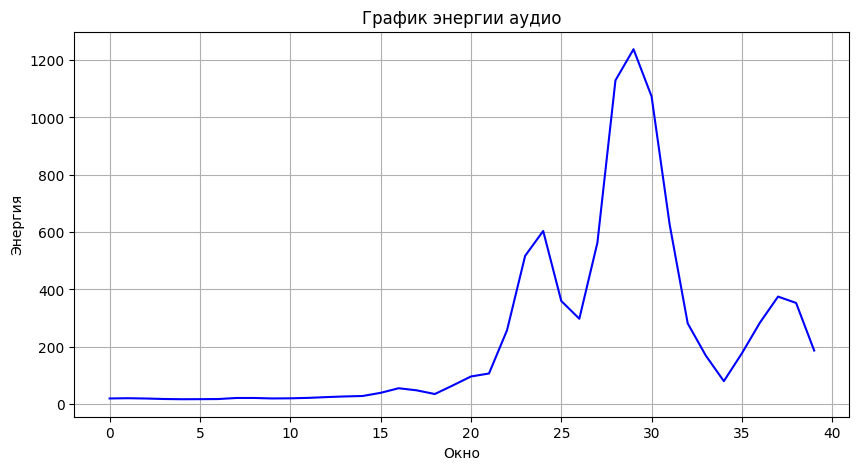

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(energy)), energy, linestyle="-", color="b")
plt.xlabel("Окно")
plt.ylabel("Энергия")
plt.title("График энергии аудио")
plt.grid(True)
plt.show()

In [73]:
mask = threshold_filter(curr_audio, file_sr, threshold=400)
signal = apply_mask(curr_audio, file_sr, mask)
Audio(signal, rate=file_sr)

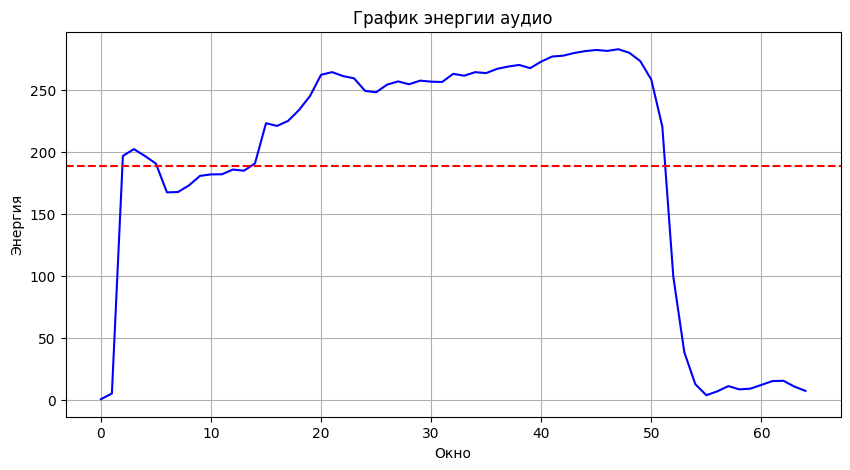

In [82]:
curr_audio, file_sr = sf.read('/kaggle/input/lw1-acc/audio_train/train/002e3e16a009d36aeafc.wav')
mask = threshold_filter(curr_audio, file_sr, draw=True, threshold_is_mean=True)
signal = apply_mask(curr_audio, file_sr, mask)
Audio(signal, rate=file_sr)

In [101]:
energies = []
for i in df[df['label']=='Harmonica']['way'].unique():
    signal, sr = sf.read(i)
    energies.append(np.mean(get_energy(signal, sr)))
threshold = np.mean(energies)

In [102]:
threshold

78.98499130702223

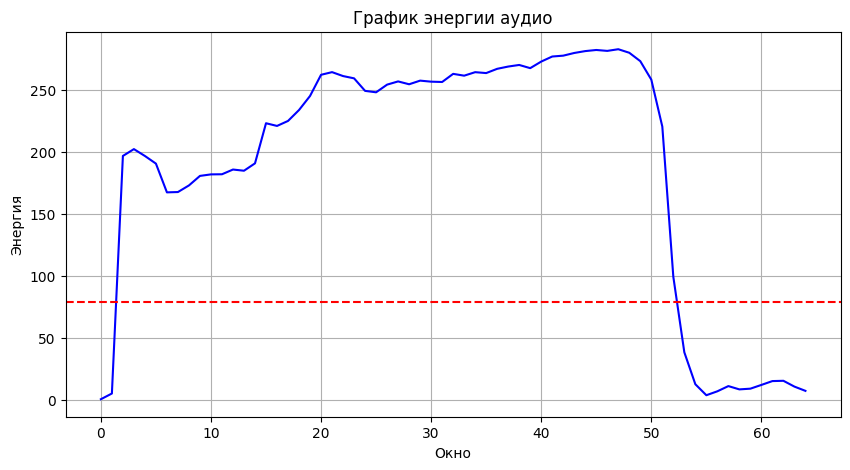

In [103]:
signal, sr = sf.read(df[df['label']=='Harmonica']['way'].iloc[0])
mask = threshold_filter(curr_audio, file_sr, threshold=threshold, draw=True)
signal = apply_mask(curr_audio, file_sr, mask)
Audio(signal, rate=file_sr)

In [201]:
threshold = {}
for label in df['label'].unique():
    energies = []
    for i in df[df['label']==label]['way'].unique():
        signal, sr = sf.read(i)
        energies.append(np.mean(get_energy(signal, sr)))
    threshold[label] = np.mean(energies)

In [109]:
# threshold

In [202]:
df['threshold'] = df['label'].apply(lambda x: threshold[x])

# Data

In [113]:
df = pd.read_csv('/kaggle/input/lw1-acc/train.csv')

<Axes: >

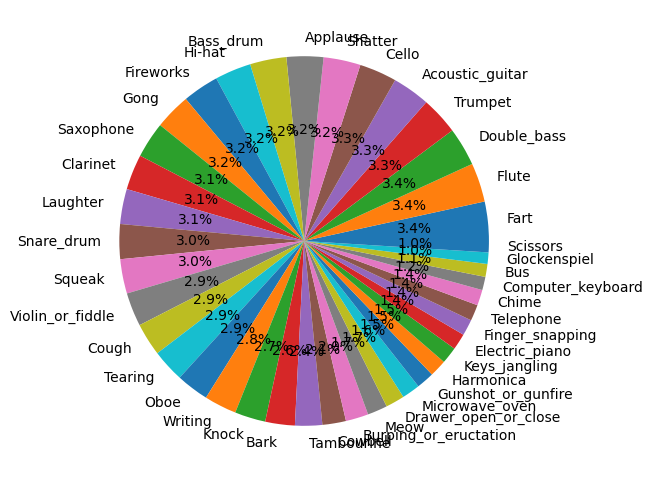

In [114]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), ylabel='')

In [115]:
way = '/kaggle/input/lw1-acc/audio_train/train/'

In [116]:
df['way'] = way + df['fname']

In [117]:
df['label_id'] = pd.factorize(df['label'])[0]

In [118]:
len(df['label_id'].unique())

41

# Get features

In [9]:
# for label in df['label'].unique():
#     if len(df[df['label']==label]['label_id'].unique()) > 1:
#         print(label)

In [203]:
train, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])

In [204]:
def get_features(data):
    features = {'spectr':[], 'mel':[], 'mfcc':[], 'labels':[]}
    for i in tqdm(range(len(data))):
        info = dict(data.iloc[i])
        curr_audio, file_sr = sf.read(info['way'])
        n_fft = min(2048, len(curr_audio))
        features['spectr'].append(np.abs(np.fft.rfft(curr_audio, n=n_fft))),
        features['mel'].append(librosa.feature.melspectrogram(y=curr_audio, sr=file_sr, n_mels=64, n_fft=n_fft))
        features['mfcc'].append(librosa.feature.mfcc(y=curr_audio, sr=file_sr, n_mfcc=13))
        features['labels'].append(info['label_id'])
    return features

In [205]:
def get_features2(data):
    features = {'spectr':[], 'mel':[], 'mfcc':[], 'labels':[]}
    for i in tqdm(range(len(data))):
        info = dict(data.iloc[i])
        first_audio, file_sr = sf.read(info['way'])
        threshold = info['threshold']
        mask = threshold_filter(first_audio, file_sr, threshold=threshold)
        curr_audio = apply_mask(first_audio, file_sr, mask)
        while len(curr_audio) == 0:
            threshold -= 2
            mask = threshold_filter(first_audio, file_sr, threshold=threshold)
            curr_audio = apply_mask(first_audio, file_sr, mask)
        n_fft = min(2048, len(curr_audio))
        features['spectr'].append(np.abs(np.fft.rfft(curr_audio, n=n_fft))),
        features['mel'].append(librosa.feature.melspectrogram(y=curr_audio, sr=file_sr, n_mels=64, n_fft=n_fft))
        features['mfcc'].append(librosa.feature.mfcc(y=curr_audio, sr=file_sr, n_mfcc=13))
        features['labels'].append(info['label_id'])
    return features

In [206]:
train_features = get_features2(train)

  0%|          | 5/4830 [00:00<01:40, 47.89it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
100%|██████████| 4830/4830 [02:24<00:00, 33.47it/s]


In [207]:
test_features = get_features2(test)

100%|██████████| 853/853 [00:24<00:00, 35.33it/s]


In [164]:
# max([mfcc.flatten().shape for mfcc in train_features['mel']])

In [165]:
# train_features['mel']

In [208]:
def pad_sequence(seq, max_len):
    seq = seq.flatten()  # Преобразуем в массив, если это список
    if len(seq) < max_len:
        return np.pad(seq, (0, max_len - len(seq)), mode='constant')
    else:
        return seq[:max_len]

max_len = max([spectr.flatten().shape for spectr in train_features['spectr']])[0] 
train_features['spectr'] = np.array([pad_sequence(m, max_len) for m in train_features['spectr']], dtype=np.float32)
test_features['spectr'] = np.array([pad_sequence(m, max_len) for m in test_features['spectr']], dtype=np.float32)
max_len = max([mfcc.flatten().shape for mfcc in train_features['mfcc']])[0] 
train_features['mfcc'] = np.array([pad_sequence(m, max_len) for m in train_features['mfcc']], dtype=np.float32)
test_features['mfcc'] = np.array([pad_sequence(m, max_len) for m in test_features['mfcc']], dtype=np.float32)
max_len = max([mel.flatten().shape for mel in train_features['mel']])[0] 
train_features['mel'] = np.array([pad_sequence(m, max_len) for m in train_features['mel']], dtype=np.float32)
test_features['mel'] = np.array([pad_sequence(m, max_len) for m in test_features['mel']], dtype=np.float32)

In [167]:
# len(train_features['mfcc']), len(train_features['mel']), len(train_features['spectr']),
# len(test_features['mfcc']), len(test_features['mel']), len(test_features['spectr'])

# Training

## TNN

In [225]:
class model_register():
    def __init__(self, ):
        self.batch_size = 64
        self.loss_function = nn.CrossEntropyLoss()
        self.lr = 1e-5
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.results = {}
        self.epoch = 0
        
    def gen_datasets(self, train, test, mode='spectr'):
        X_train, X_test, y_train, y_test = train[mode], test[mode], train['labels'], test['labels']
        inputs_train = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        targets_train = torch.tensor([i for i in y_train], dtype=torch.long)
        inputs_test = torch.tensor(X_test, dtype=torch.float32)
        targets_test = torch.tensor([i for i in y_test], dtype=torch.long)
        self.input_dim = inputs_train.shape[1:]
        self.input_dim = torch.prod(torch.tensor(model.input_dim))
        inputs_train = inputs_train.view(inputs_train.shape[0], self.input_dim)
        inputs_test = inputs_test.view(inputs_test.shape[0], self.input_dim)
        train = data_utils.TensorDataset(inputs_train.to(self.device), targets_train.to(self.device))
        test = data_utils.TensorDataset(inputs_test.to(self.device), targets_test.to(self.device))
        self.trainset = torch.utils.data.DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self.testset = torch.utils.data.DataLoader(test, batch_size=self.batch_size, shuffle=False)

    def get_model(self):
        self.model = Classifier(self.input_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self, epochs=10):
        for epoch in range(epochs):
            with tqdm(self.trainset, desc=f"Epoch {epoch+1}/{epochs}", leave=True) as pbar:
                for X, y in pbar: 
                    self.optimizer.zero_grad()
                    out = self.model(X)
                    out = out.view(-1, out.shape[-1])
                    loss = self.loss_function(out, y)
                    loss.backward()
                    self.optimizer.step()
                    pbar.set_postfix(loss=loss.item())

    def test(self):
        self.model.eval()
        predictions = []
        targets = []
    
        with torch.no_grad():
            with tqdm(self.testset, desc="Testing", leave=True) as pbar:
                for X, y in pbar:
                    X, y = X.to(self.device), y.cpu()
    
                    # Получаем выход модели
                    output = self.model(X)
    
                    # Предсказания
                    preds = torch.argmax(output, dim=-1).cpu().numpy()
    
                    # Сохранение истинных значений и предсказаний
                    targets.extend(y.numpy())
                    predictions.extend(preds)
    
        # Вычисляем F1-score (macro-avg для несбалансированных классов)
        f1 = f1_score(targets, predictions, average="macro")
    
        print(f"F1-score (macro): {f1:.4f}")

In [226]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=4, nheads=8, num_classes=41, dropout_rate=0.3):
        super().__init__()

        self.hidden_dim = hidden_dim * 8

        self.fc1 = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim * 4, dropout=dropout_rate
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(hidden_dim, num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  

        x = self.transformer(x)
        x = x.squeeze(0)

        x = self.dropout(x)

        out = self.fc_out(x)  
        return out  

In [192]:
model = model_register()
model.gen_datasets(train_features, test_features, 'spectr')
model.get_model()
model.train()
model.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing: 100%|██████████| 14/14 [00:00<00:00, 366.01it/s]

F1-score (macro): 0.2252


In [230]:
model = model_register()
model.gen_datasets(train_features, test_features, 'spectr')
model.get_model()
model.train(epochs=60)
model.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing: 100%|██████████| 14/14 [00:00<00:00, 369.81it/s]

F1-score (macro): 0.3521


In [194]:
model = model_register()
model.gen_datasets(train_features, test_features, 'mfcc')
model.get_model()
model.train()
model.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing: 100%|██████████| 14/14 [00:00<00:00, 360.50it/s]

F1-score (macro): 0.2042


In [231]:
model = model_register()
model.gen_datasets(train_features, test_features, 'mfcc')
model.get_model()
model.train(epochs=60)
model.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing: 100%|██████████| 14/14 [00:00<00:00, 361.10it/s]

F1-score (macro): 0.2781


In [196]:
model = model_register()
model.gen_datasets(train_features, test_features, 'mel')
model.get_model()
model.train()
model.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing: 100%|██████████| 14/14 [00:00<00:00, 210.21it/s]

F1-score (macro): 0.1623


In [232]:
model = model_register()
model.gen_datasets(train_features, test_features, 'mfcc')
model.get_model()
model.train(epochs=60)
model.test()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing: 100%|██████████| 14/14 [00:00<00:00, 362.63it/s]

F1-score (macro): 0.2934


## SVM

In [177]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [28]:
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(train_features['spectr'], train_features['labels'])
pred = svm_classifier.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.1914


In [26]:
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(train_features['mel'], train_features['labels'])
pred = svm_classifier.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.1354


In [25]:
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(train_features['mfcc'], train_features['labels'])
pred = svm_classifier.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.2061


## Random Forest

In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [213]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Количество деревьев
    'max_depth': [None, 10, 20, 30, 50],  # Глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разбиения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество образцов в листе
    'bootstrap': [True, False]  # Использовать ли бутстрапинг
}

rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, 
    n_iter=20, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42
)
random_search.fit(train_features['spectr'], train_features['labels'])
print("Лучшие параметры:", random_search.best_params_)
best_rf = random_search.best_estimator_
pred = best_rf.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}
F1-score (macro): 0.4363


In [221]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Количество деревьев
    'max_depth': [None, 10, 20, 30, 50],  # Глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разбиения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество образцов в листе
    'bootstrap': [True, False]  # Использовать ли бутстрапинг
}

rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, 
    n_iter=20, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42
)
random_search.fit(train_features['mel'], train_features['labels'])
print("Лучшие параметры:", random_search.best_params_)
best_rf = random_search.best_estimator_
pred = best_rf.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}
F1-score (macro): 0.3995


In [222]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Количество деревьев
    'max_depth': [None, 10, 20, 30, 50],  # Глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разбиения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество образцов в листе
    'bootstrap': [True, False]  # Использовать ли бутстрапинг
}

rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, 
    n_iter=20, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42
)
random_search.fit(train_features['mfcc'], train_features['labels'])
print("Лучшие параметры:", random_search.best_params_)
best_rf = random_search.best_estimator_
pred = best_rf.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}
F1-score (macro): 0.3806


In [209]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features['spectr'], train_features['labels'])
pred = rf_classifier.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.4050


In [210]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features['mel'], train_features['labels'])
pred = rf_classifier.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.3547


In [211]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features['mfcc'], train_features['labels'])
pred = rf_classifier.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.3483


## KNN

In [33]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features['spectr'], train_features['labels'])
pred = knn_classifier.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.2837


In [34]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features['mel'], train_features['labels'])
pred = knn_classifier.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.1382


In [35]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features['mfcc'], train_features['labels'])
pred = knn_classifier.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.2345


## Naive Bayes

In [36]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_features['spectr'], train_features['labels'])
pred = nb_classifier.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.1318


In [37]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_features['mel'], train_features['labels'])
pred = nb_classifier.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.0387


In [38]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_features['mfcc'], train_features['labels'])
pred = nb_classifier.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.0101


## Ada Boost

In [39]:
ada_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_classifier.fit(train_features['spectr'], train_features['labels'])
pred = ada_classifier.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.0201


In [40]:
ada_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_classifier.fit(train_features['mel'], train_features['labels'])
pred = ada_classifier.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.0389


In [41]:
ada_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_classifier.fit(train_features['mfcc'], train_features['labels'])
pred = ada_classifier.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

F1-score (macro): 0.0247


## QDA

In [42]:
qda_classifier = QuadraticDiscriminantAnalysis()
qda_classifier.fit(train_features['spectr'], train_features['labels'])
pred = qda_classifier.predict(test_features['spectr'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1-score (macro): 0.0389


In [43]:
qda_classifier = QuadraticDiscriminantAnalysis()
qda_classifier.fit(train_features['mel'], train_features['labels'])
pred = qda_classifier.predict(test_features['mel'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1-score (macro): 0.0313


In [44]:
qda_classifier = QuadraticDiscriminantAnalysis()
qda_classifier.fit(train_features['mfcc'], train_features['labels'])
pred = qda_classifier.predict(test_features['mfcc'])
f1 = f1_score(test_features['labels'], pred, average="macro")
print(f"F1-score (macro): {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1-score (macro): 0.0449


## Result

In [234]:
df = pd.DataFrame({'models':   ['Transformer-10', 'Transformer-10', 'Transformer-10', 
                           'Transformer-10ADmean', 'Transformer-10ADmean', 'Transformer-10ADmean', 
                           'Transformer-10ADmin', 'Transformer-10ADmin', 'Transformer-10ADmin', 
                           'Transformer-30', 'Transformer-30', 'Transformer-30',
                           'Transformer-30ADmean', 'Transformer-30ADmean', 'Transformer-30ADmean',
                           'Transformer-60ADmean', 'Transformer-60ADmean', 'Transformer-60ADmean',
                           'Transformer-30ADmin', 'Transformer-30ADmin', 'Transformer-30ADmin',
                           'SVM', 'SVM', 'SVM', 
                           'RF', 'RF', 'RF', 
                           'RF-ADmean', 'RF-ADmean', 'RF-ADmean',
                           'RF-ADmeanRS', 'RF-ADmeanRS', 'RF-ADmeanRS',
                           'RF-ADmin', 'RF-ADmin', 'RF-ADmin',
                           'KNN', 'KNN', 'KNN',
                           'NB', 'NB', 'NB',
                           'AB', 'AB', 'AB',
                           'QDA', 'QDA', 'QDA',
                          ],
              'Features': ['spectr', 'mfcc', 'mel', 
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel', 
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel', 
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel', 
                           'spectr', 'mfcc', 'mel', 
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                           'spectr', 'mfcc', 'mel',
                          ],
              'F1-macro': [0.1965, 0.1994, 0.1825,  #Transformer-10
                           0.2048, 0.1522, 0.1558,  #Transformer-10ADmean
                           0.2252, 0.2042, 0.1623,  #Transformer-10ADmin
                           0.2800, 0.2508, 0.2752,  #Transformer-30
                           0.3235, 0.2680, 0.2525,  #Transformer-30ADmean
                           0.3521, 0.2781, 0.2934,  #Transformer-60ADmean
                           0.3123, 0.2841, 0.2782,  #Transformer-30ADmin
                           0.1914, 0.1354, 0.2061,  #SVM
                           0.2459, 0.3169, 0.3263,  #RF
                           0.4050, 0.3547, 0.3483,  #RF-ADmean
                           0.4363, 0.3995, 0.3806,  #RF-ADmeanRS
                           0.3208, 0.3228, 0.3656, #RF-ADmin
                           0.2837, 0.1382, 0.2345,  #KNN
                           0.1318, 0.0387, 0.0101,  #NB
                           0.0201, 0.0389, 0.0247,  #AB
                           0.0389, 0.0313, 0.0449,  #QDA
                          ]
             })

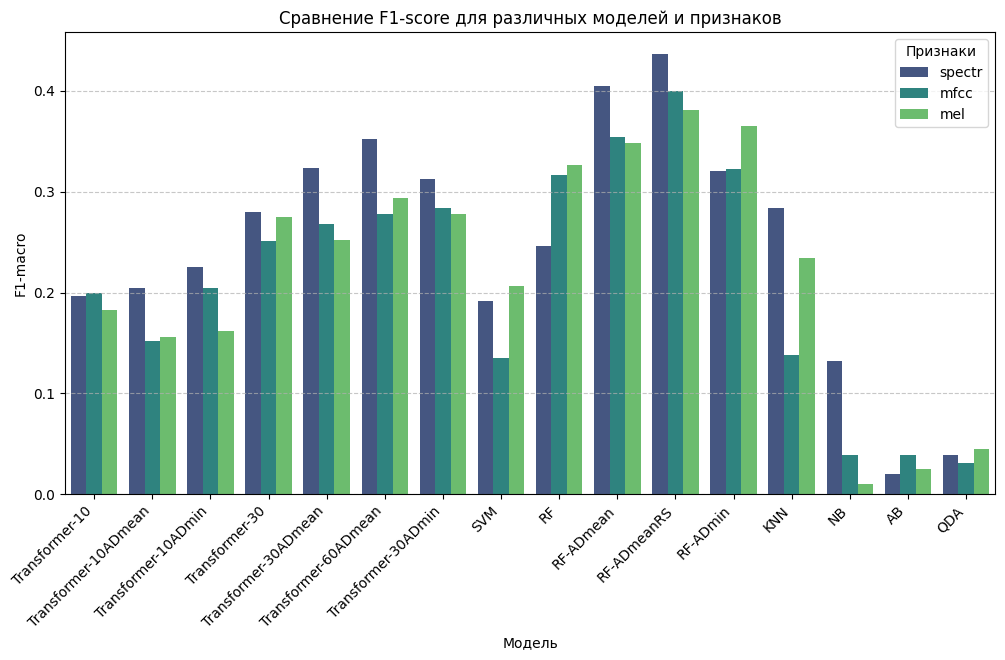

In [235]:
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="models", y="F1-macro", hue="Features", palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Модель")
plt.ylabel("F1-macro")
plt.title("Сравнение F1-score для различных моделей и признаков")
plt.legend(title="Признаки")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()